**SOURCES**

https://www.youtube.com/watch?v=Osj0Z6rwJB4&t=206s

https://github.com/curiousily/Getting-Things-Done-with-Pytorch/blob/master/08.sentiment-analysis-with-bert.ipynb


# Installables

Install Torch:
`pip3 install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html`

Install Watermark:
`!pip install -q -U watermark`

Install Transformers:
`!pip install -qq transformers`

# Imports and System Configurations

nvidia-smi (also NVSMI) provides monitoring and management capabilities for each of NVIDIA's Tesla, Quadro, GRID and GeForce devices from Fermi.

Source - https://developer.download.nvidia.com/compute/DCGM/docs/nvidia-smi-367.38.pdf


In [1]:
!nvidia-smi

Mon May 24 20:20:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 452.66       Driver Version: 452.66       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro T1000       WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   42C    P8     5W /  N/A |    577MiB /  4096MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

numpy       : 1.19.5
pandas      : 1.2.4
torch       : 1.8.1+cu111
transformers: 4.6.0



## Basic imports

In [3]:
# basic imports
import numpy as np
import pandas as pd

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# for iteration operations
from collections import defaultdict

# text imports
from textwrap import wrap

## Import Torch and Hugging Face Transformers

In [4]:
%%time
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

Wall time: 2.53 s


## Visualization Imports and Settings

In [5]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

In [6]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Tokenization

In [7]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased' # for cased
# PRE_TRAINED_MODEL_NAME = 'bert-base-uncased' # for uncased

In [8]:
%%time
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Wall time: 1.73 s


In [9]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [10]:
%%time
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]
Wall time: 0 ns


## Tokenization Tests

### Test uncased tokenizer

In [11]:
PRE_TRAINED_MODEL_NAME_UNCASED = 'bert-base-uncased'
tokenizer_uncased = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME_UNCASED)
tokens_uncased = tokenizer_uncased.tokenize(sample_txt)
token_ids_uncased = tokenizer_uncased.convert_tokens_to_ids(tokens_uncased)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens_uncased}')
print(f'Token IDs: {token_ids_uncased}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188, 2005, 1016, 3134, 1012]


In [12]:
tokens[-1], token_ids[-1]

('.', 119)

In [13]:
# For sentence separation
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [14]:
# For indicating classification
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [15]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [16]:
# All unknown words in BERT training set
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

Reference for encode_plus:
 https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus

In [17]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\roynab\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2104: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [18]:
encoding['input_ids']

tensor([[ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
         1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

In [19]:
print(tokens)
print(token_ids)

['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
[1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


### Trial with two sentences

In [20]:
sample_txt_two_sent = 'When was I last outside? I am stuck at home for 2 weeks. I do not know where I am going.'

In [21]:
tokens_two_sent = tokenizer.tokenize(sample_txt_two_sent)
token_ids_two_sent = tokenizer.convert_tokens_to_ids(tokens_two_sent)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens_two_sent}')
print(f'Token IDs: {token_ids_two_sent}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.', 'I', 'do', 'not', 'know', 'where', 'I', 'am', 'going', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119, 146, 1202, 1136, 1221, 1187, 146, 1821, 1280, 119]


In [22]:
encoding_two_sent = tokenizer.encode_plus(
  sample_txt_two_sent,
  max_length=32, # Set the max length
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True, # Add '[PAD]'
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding_two_sent['input_ids']

tensor([[ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
         1111,  123, 2277,  119,  146, 1202, 1136, 1221, 1187,  146, 1821, 1280,
          119,  102,    0,    0,    0,    0,    0,    0]])

Not automatically detecting '?' or '.' in between the whole text

## Attention mask

In [23]:
len(encoding['attention_mask'][0]), encoding['attention_mask']

(32,
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0]]))

In [24]:
len(encoding_two_sent['attention_mask'][0]), encoding_two_sent['attention_mask']

(32,
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 0, 0, 0, 0, 0, 0]]))

## Convert IDs to Tokens

In [25]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [26]:
print(tokenizer.convert_ids_to_tokens(encoding_two_sent['input_ids'][0]))

['[CLS]', 'When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.', 'I', 'do', 'not', 'know', 'where', 'I', 'am', 'going', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


# Google Play App Reviews Data

In [29]:
# !gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
# !gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

In [27]:
df = pd.read_csv("Data/GoogleAppsReviews/reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [28]:
df.isna().sum()

userName                   0
userImage                  0
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    2213
at                         0
replyContent            8379
repliedAt               8379
sortOrder                  0
appId                      0
dtype: int64

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


## Target Balance Assessment

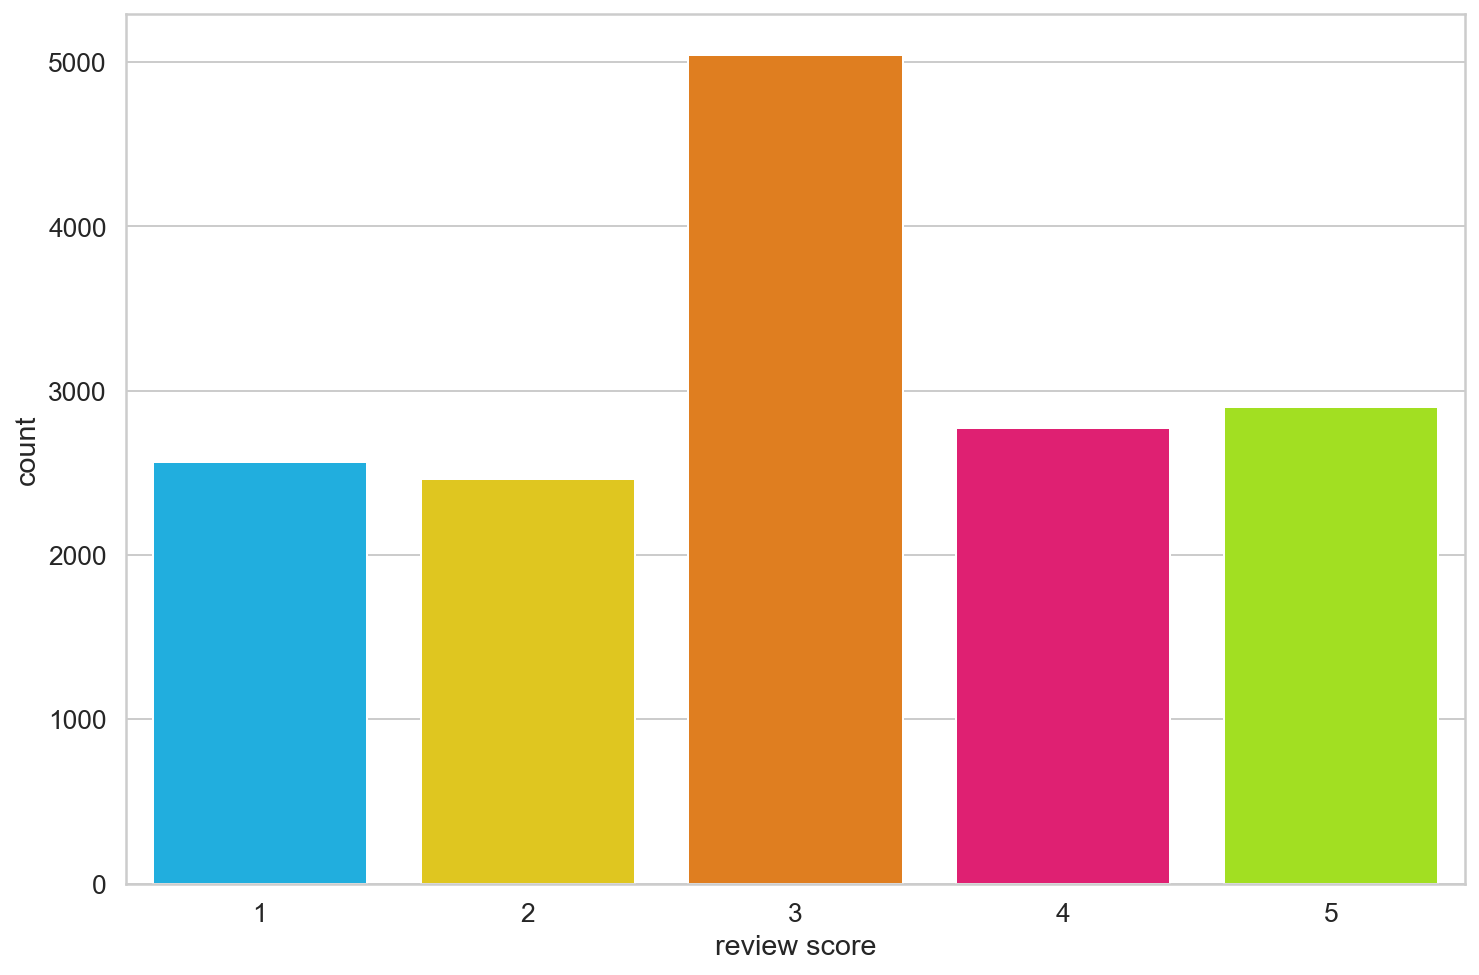

In [30]:
sns.countplot(x='score', data=df)
plt.xlabel('review score')
plt.show()

In [31]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return -1, 'negative'
    elif rating == 3:
        return 0, 'neutral'
    else: 
        return 1, 'positive'

df['sentiment'], df['sentiment_label'] = zip(*df.score.apply(to_sentiment))

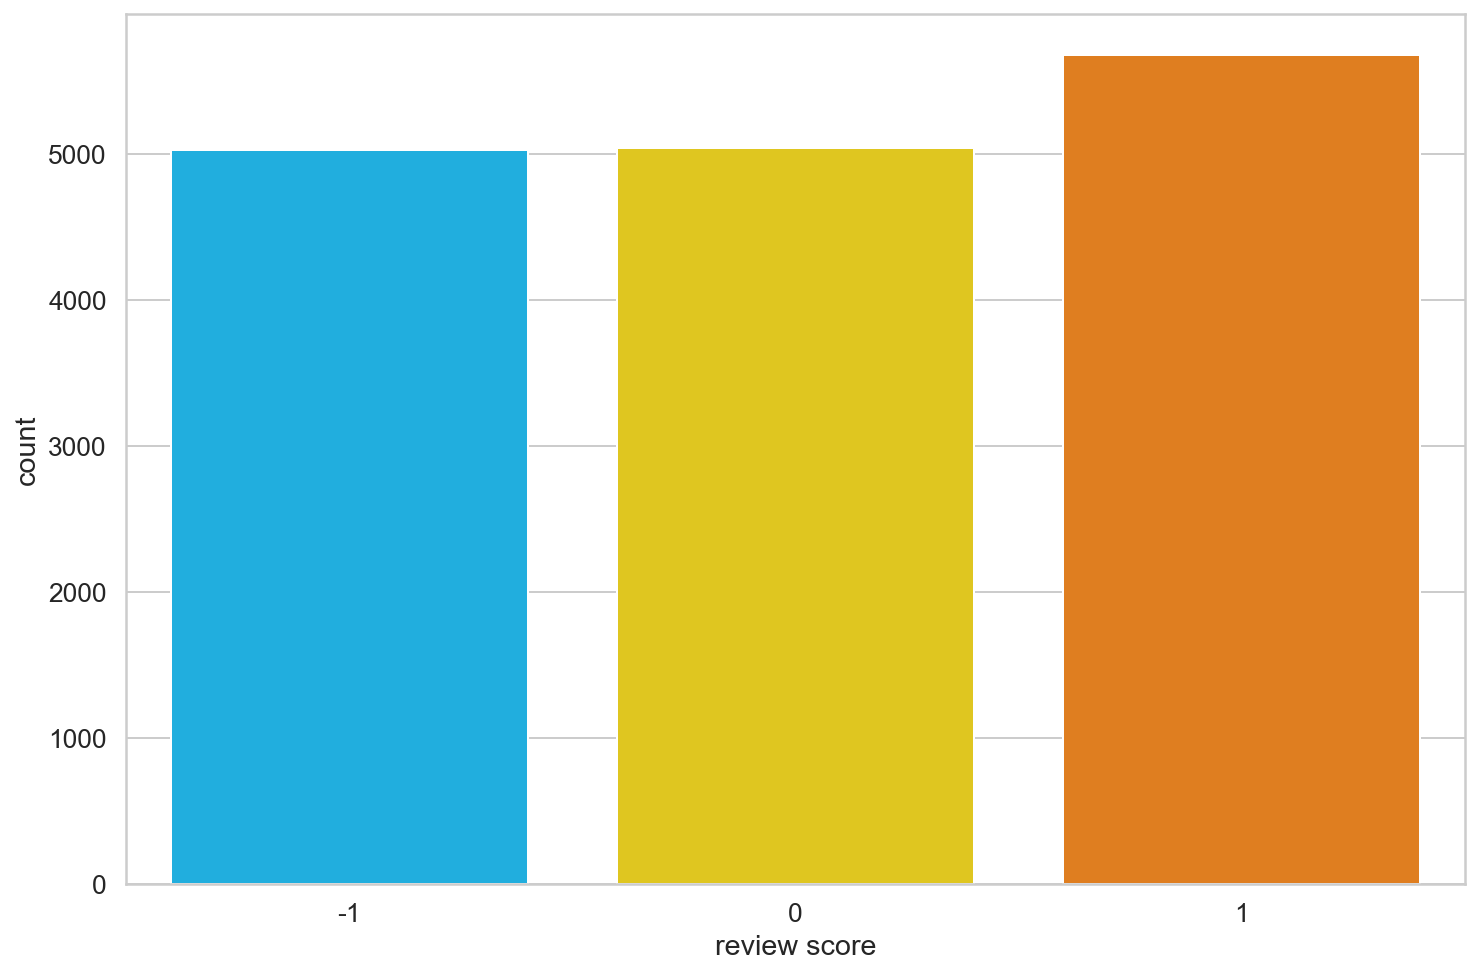

In [32]:
sns.countplot(x='sentiment', data=df)
plt.xlabel('review score')
plt.show()

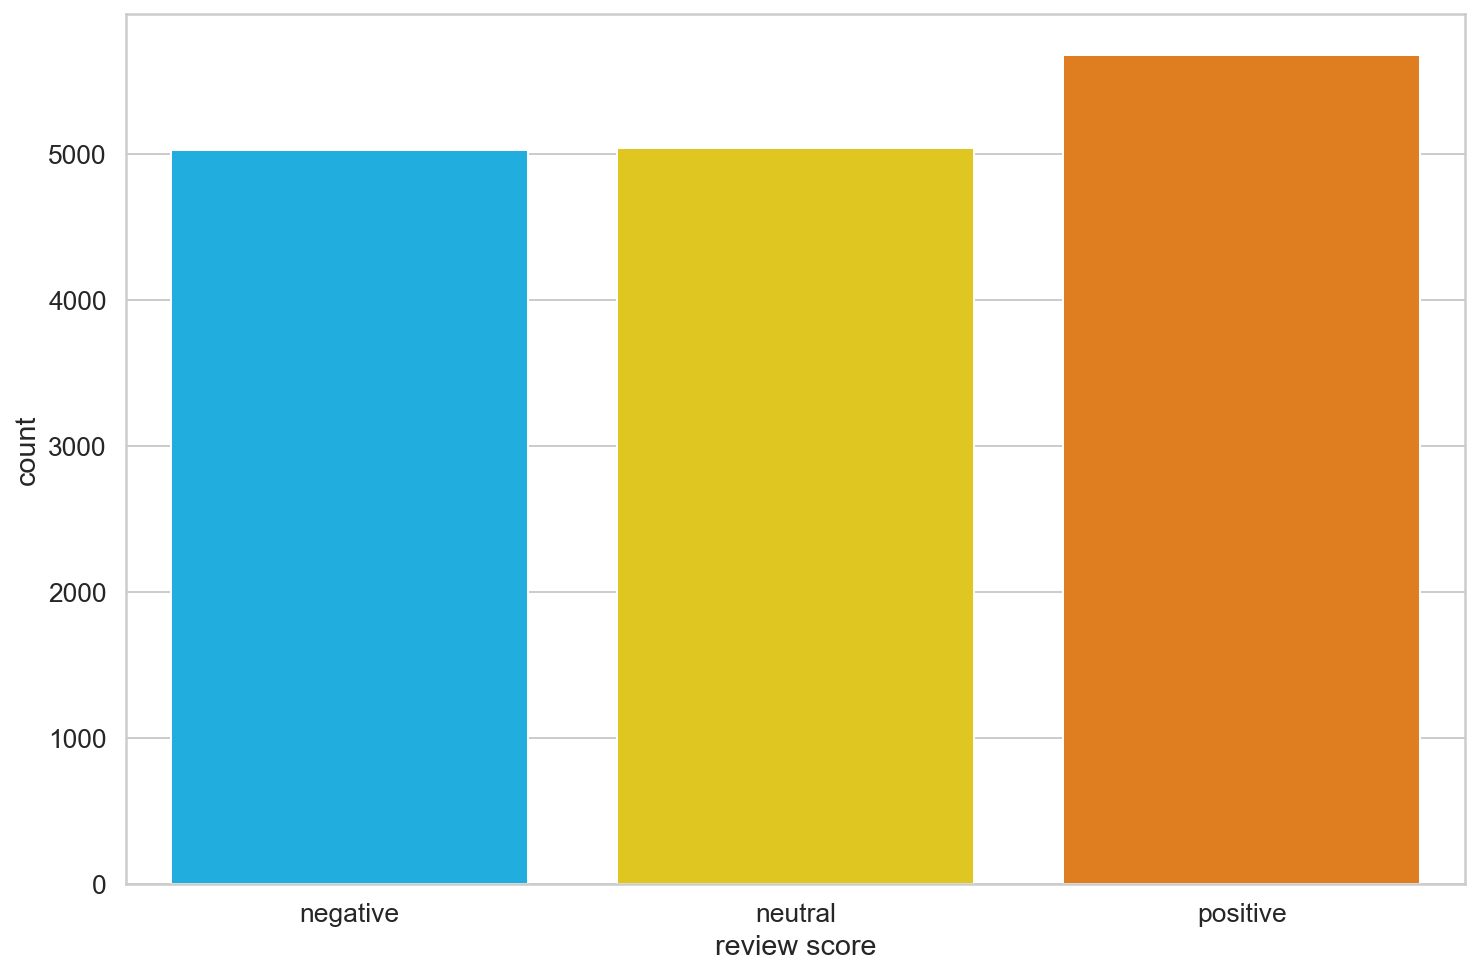

In [33]:
sns.countplot(x='sentiment_label', data=df)
plt.xlabel('review score')
plt.show()

## Max Length Selection

In [34]:
%%time
token_lens = []

# Using the same tokenizer
for txt in df.content:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Wall time: 12.3 s


Text(0.5, 11.552000000000007, 'Token count')

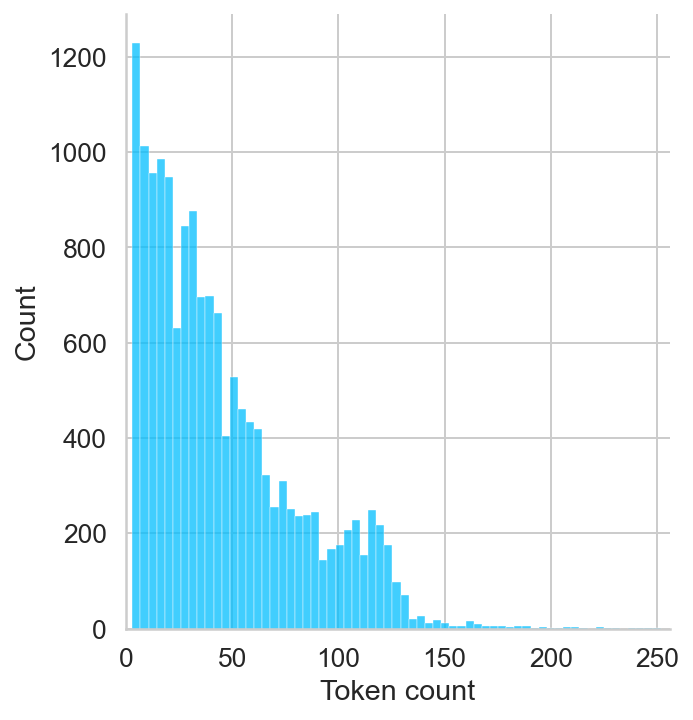

In [35]:
sns.displot(token_lens)
plt.xlim([0, 256])
plt.xlabel('Token count')

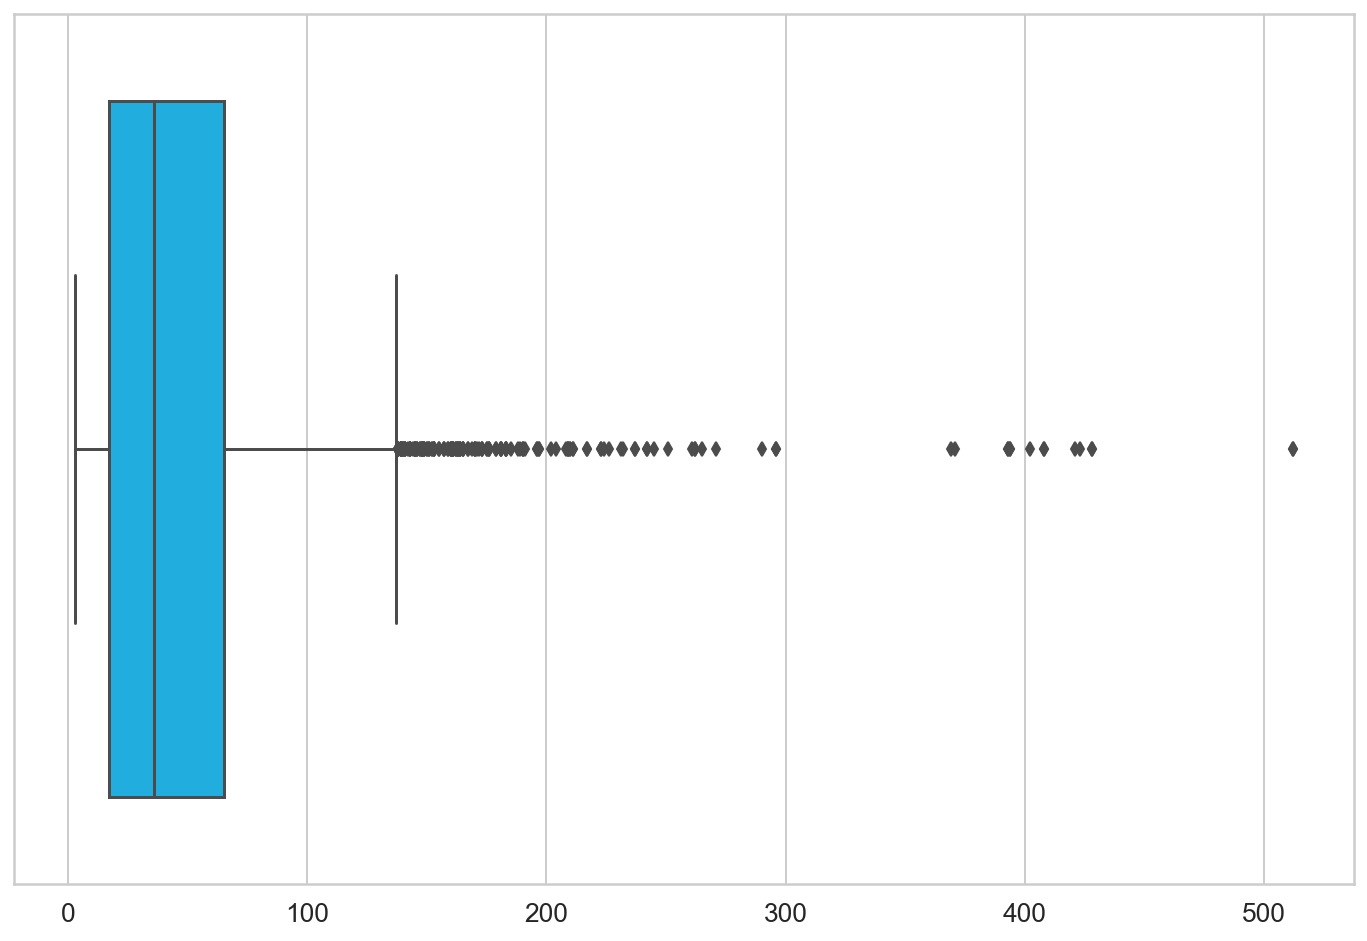

In [36]:
sns.boxplot(x = token_lens)
plt.show()

In [37]:
Q1 = np.percentile(token_lens, 25)
# print(Q1)
Q3 = np.percentile(token_lens, 75)
# # print(Q3)
IQR = Q3 - Q1
# print(IQR)
Q3 + (1.5 * IQR)

137.0

In [38]:
# So let us take a safe side value of 160
MAX_LEN = 160

## Data Prep

In [39]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [40]:
df_train.shape, df_val.shape, df_test.shape

((14171, 13), (787, 13), (788, 13))

In [41]:
BATCH_SIZE = 16

In [42]:
# ds_val = GPReviewDataset(reviews=df_val.content.to_numpy(),
#                            targets=df_val.sentiment.to_numpy(),
#                            tokenizer=tokenizer,
#                            max_len=MAX_LEN)

# val_data_loader = DataLoader(ds_val, batch_size=BATCH_SIZE, num_workers=4)

In [43]:
# ds_test = GPReviewDataset(reviews=df_test.content.to_numpy(),
#                            targets=df_test.sentiment.to_numpy(),
#                            tokenizer=tokenizer,
#                            max_len=MAX_LEN)

# test_data_loader = DataLoader(ds_test, batch_size=BATCH_SIZE, num_workers=4)

In [44]:
# def create_data_loader(df, tokenizer, max_len, batch_size):
#     ds = GPReviewDataset(reviews=df.content.to_numpy(),
#                          targets=df.sentiment.to_numpy(),
#                          tokenizer=tokenizer,
#                          max_len=max_len)
#     print(type(ds))
#     return DataLoader(ds, batch_size=batch_size, num_workers=4)

In [45]:
import GPReviewDataModel

In [46]:
BATCH_SIZE = 16

train_data_loader = GPReviewDataModel.create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = GPReviewDataModel.create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = GPReviewDataModel.create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Error here resolved with - 

https://medium.com/@grvsinghal/speed-up-your-python-code-using-multiprocessing-on-windows-and-jupyter-or-ipython-2714b49d6fac

In [47]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [48]:
type(train_data_loader)

torch.utils.data.dataloader.DataLoader

In [49]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


# Sentiment Classification with BERT and Hugging Face

In [50]:
# Load the basic BERT model and then will build a classifier on top of it
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [51]:
# Recall the sample text
encoding['input_ids']

tensor([[ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
         1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

In [52]:
bert_model_obj = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [53]:
bert_model_obj.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [54]:
bert_model_obj['last_hidden_state'].shape, bert_model_obj['pooler_output'].shape

(torch.Size([1, 32, 768]), torch.Size([1, 768]))

In [55]:
#Examples of BERT configs that are customizable

bert_model.config.early_stopping, bert_model.config.hidden_size, bert_model.config.hidden_dropout_prob

(False, 768, 0.1)

## Build the classifier

In [56]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3) # dropout layer for some regularization
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes) # fully-connected layer for output

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids,
                                     attention_mask=attention_mask,
                                     return_dict=False # Latest change
                                    )
        output = self.drop(pooled_output)
        return self.out(output)

In [57]:
class_names = ['negative', 'neutral', 'positive']

In [58]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [59]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [60]:
# To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2332, 0.4717, 0.2951],
        [0.2219, 0.3612, 0.4168],
        [0.3589, 0.2427, 0.3984],
        [0.2221, 0.3218, 0.4561],
        [0.5762, 0.2056, 0.2181],
        [0.2249, 0.4422, 0.3329],
        [0.2750, 0.3181, 0.4069],
        [0.3732, 0.2454, 0.3813],
        [0.3927, 0.1892, 0.4181],
        [0.3349, 0.1948, 0.4703],
        [0.3043, 0.2263, 0.4695],
        [0.3710, 0.1894, 0.4396],
        [0.2090, 0.4449, 0.3462],
        [0.3396, 0.2594, 0.4010],
        [0.3456, 0.2260, 0.4284],
        [0.1500, 0.3302, 0.5198]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [61]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [63]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler,
                n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [65]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [68]:
import gc
# del variables
gc.collect()

10281

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn,
                                        optimizer, device, scheduler,
                                        len(df_train))

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device,
                                   len(df_val))

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc